In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

2023-03-03 17:57:17.336057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load and Understand Our Data

In [2]:
EPOCHS = 20
BATCH_SIZE = 10

In [3]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
print("X Train shape:", x_train.shape)
print(x_train[0][0][0])
print("Looks like we need to convert in between (0,1) by divide elements by 255 \n")
print("Y Train shape:", y_train.shape)
print(np.unique(y_train))
print("Looks like we have 10 unique classes for our data")

X Train shape: (50000, 32, 32, 3)
[59 62 63]
Looks like we need to convert in between (0,1) by divide elements by 255 

Y Train shape: (50000, 1)
[0 1 2 3 4 5 6 7 8 9]
Looks like we have 10 unique classes for our data


In [5]:
# Convert RGB to decimal in between [0,1] => 255 = 1, 0 = 0
x_train, x_test = x_train / 255.0, x_test / 255.0

# Flatten our target dataset
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape)
print("y_train.shape", y_train.shape)

x_train.shape: (50000, 32, 32, 3)
y_train.shape (50000,)


In [6]:
# Get number of target classes
k_class = len(np.unique(y_train))
print("Number of Classes:", k_class)

Number of Classes: 10


In [14]:
def plot_acc_and_loss(acc, val_acc, loss, val_loss, epochs_range, condition):
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle("Model: Sparse Categorical Entropy Loss, Adam optimizer, 3 Layers")
    plt.savefig('./{}.png' .format(condition))
    plt.show()

In [16]:
def get_history(fitted_model):
    acc = fitted_model.history['accuracy']
    avg_acc = np.mean(acc)
    val_acc = fitted_model.history['val_accuracy']
    avg_valAcc = np.mean(val_acc)

    loss = fitted_model.history['loss']
    avg_loss = np.mean(loss)
    val_loss = fitted_model.history['val_loss']
    avg_val_loss = np.mean(val_loss)

    print("Average Training accuracy: {:.2f}%".format(avg_acc*100))
    print("Average Validation accuracy: {:.2f}%".format(avg_valAcc*100))
    print("Average Loss: {:.2f}".format(avg_loss))
    print("Average Validation Loss: {:.2f}".format(avg_val_loss))

    return acc, val_acc, loss, val_loss

### Model

In [7]:
from tensorflow.keras import layers,models,optimizers
from tensorflow.keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

In [8]:
# Get input dimension
input_dimension = x_train[0].shape

# Input layer
inputs = Input(shape=input_dimension)

# Convolution layers
x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

# Fully connected layer
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(k_class, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

2023-03-03 17:57:24.283521: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0     

In [10]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [11]:
model_1 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=EPOCHS)

Epoch 1/20
1563/1563 [==============================] - 232s 147ms/step - loss: 1.3141 - accuracy: 0.5438 - val_loss: 1.1426 - val_accuracy: 0.6221
Epoch 2/20
1563/1563 [==============================] - 233s 149ms/step - loss: 0.8540 - accuracy: 0.7034 - val_loss: 0.8081 - val_accuracy: 0.7243
Epoch 3/20
1563/1563 [==============================] - 236s 151ms/step - loss: 0.7035 - accuracy: 0.7574 - val_loss: 0.7864 - val_accuracy: 0.7374
Epoch 4/20
1563/1563 [==============================] - 241s 154ms/step - loss: 0.5978 - accuracy: 0.7955 - val_loss: 0.6186 - val_accuracy: 0.7940
Epoch 5/20
1563/1563 [==============================] - 239s 153ms/step - loss: 0.5051 - accuracy: 0.8275 - val_loss: 0.7690 - val_accuracy: 0.7567
Epoch 6/20
1563/1563 [==============================] - 241s 154ms/step - loss: 0.4260 - accuracy: 0.8540 - val_loss: 0.5833 - val_accuracy: 0.8071
Epoch 7/20
1563/1563 [==============================] - 246s 157ms/step - loss: 0.3592 - accuracy: 0.8748 - val_

Average Training accuracy: 88.11%
Average Validation accuracy: 79.64%
Average Loss: 0.35
Average Validation Loss: 0.73


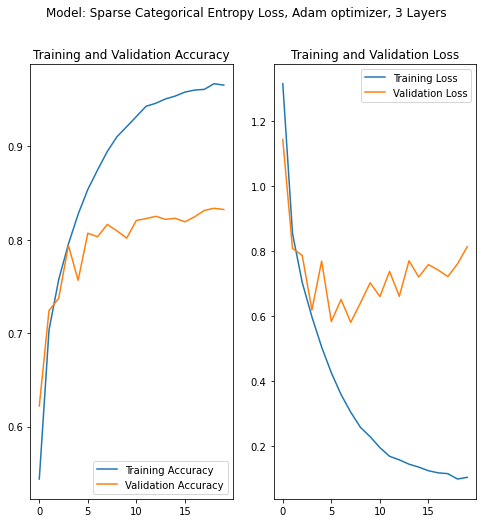

In [17]:
epochs_range = range(EPOCHS)

acc, val_acc, loss, val_loss = get_history(model_1)

plot_acc_and_loss(acc, val_acc, loss, val_loss, epochs_range, "No Image Augmentation; have call back")

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

train_generator = data_generator.flow(x_train, y_train, BATCH_SIZE)

steps_per_epoch = x_train.shape[0] // BATCH_SIZE

fitted_model = model.fit(train_generator, 
                         validation_data=(x_test, y_test), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=EPOCHS)

Epoch 1/20
5000/5000 [==============================] - 381s 76ms/step - loss: 0.6415 - accuracy: 0.7781 - val_loss: 0.5766 - val_accuracy: 0.8057
Epoch 2/20
5000/5000 [==============================] - 398s 80ms/step - loss: 0.6172 - accuracy: 0.7882 - val_loss: 0.6039 - val_accuracy: 0.7998
Epoch 3/20
5000/5000 [==============================] - 388s 78ms/step - loss: 0.6094 - accuracy: 0.7926 - val_loss: 0.5756 - val_accuracy: 0.8061
Epoch 4/20
5000/5000 [==============================] - 396s 79ms/step - loss: 0.6031 - accuracy: 0.7931 - val_loss: 0.5292 - val_accuracy: 0.8209
Epoch 5/20
5000/5000 [==============================] - 405s 81ms/step - loss: 0.5869 - accuracy: 0.8007 - val_loss: 0.5514 - val_accuracy: 0.8123
Epoch 6/20
5000/5000 [==============================] - 403s 81ms/step - loss: 0.5838 - accuracy: 0.8027 - val_loss: 0.5671 - val_accuracy: 0.8081
Epoch 7/20
5000/5000 [==============================] - 403s 81ms/step - loss: 0.5763 - accuracy: 0.8032 - val_loss: 0

Average Training accuracy: 80.91%
Average Validation accuracy: 82.00%
Average Loss: 0.56
Average Validation Loss: 0.54


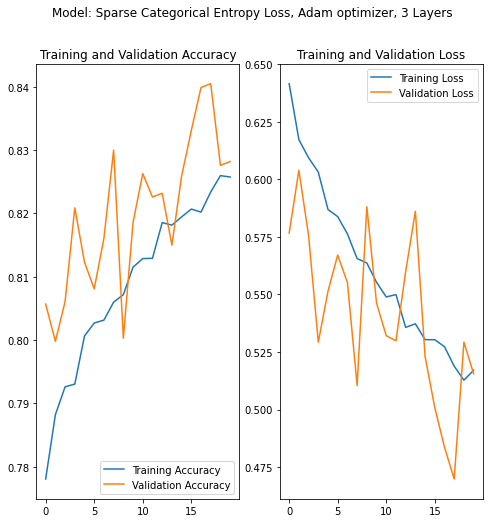

In [20]:
epochs_range = range(EPOCHS)
acc_1, val_acc_1, loss_1, val_loss_1 = get_history(fitted_model)

plot_acc_and_loss(acc_1, val_acc_1, loss_1, val_loss_1, epochs_range, "Image Augmentation")

In [21]:
model.save_weights("model_image_augmented.h5")